In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *
import random

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
random.seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

# train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size, identities_weight=0.04, identitity_weight_decay=0.9)

created reasoner with 3283 parameters
created 40 encoders with 1270 parameters each


In [4]:
trained_reasoner.load_state_dict(T.load('local/out/exp/20240710T211205/reasoner.pt'))


<All keys matched successfully>

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te[0],
    'X': data_te[1],
    'y': data_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col])
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col])

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_te_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_te_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [6]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    if reasoner_name == 'trained reasoner':
        train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger,identities_weight=0.045, identitity_weight_decay=0.9)
    #else:
        #train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 751/750 | loss 1.1805 | val loss 1.0651 | acc 0.6480 | f1 0.4072 | prec 0.3212 | recall 0.5561 | roc auc 0.6572 | pr auc 0.4848 | elapsed 13.65s
train epoch 01/10 | batch 751/750 | loss 1.0564 | val loss 0.8378 | acc 0.7050 | f1 0.4522 | prec 0.3791 | recall 0.5601 | roc auc 0.7048 | pr auc 0.5313 | elapsed 27.27s
train epoch 02/10 | batch 751/750 | loss 0.8111 | val loss 0.6644 | acc 0.7549 | f1 0.5052 | prec 0.4501 | recall 0.5756 | roc auc 0.7521 | pr auc 0.5856 | elapsed 24.42s
train epoch 03/10 | batch 751/750 | loss 0.6291 | val loss 0.5372 | acc 0.7943 | f1 0.5571 | prec 0.5235 | recall 0.5952 | roc auc 0.7960 | pr auc 0.6433 | elapsed 25.20s
train epoch 04/10 | batch 751/750 | loss 0.4942 | val loss 0.4449 | acc 0.8256 | f1 0.6069 | prec 0.5950 | recall 0.6193 | roc auc 0.8343 | pr auc 0.6998 | elapsed 24.18s
train epoch 05/10 | batch 751/750 | loss 0.3973 | val loss 0.3792 | acc 0.8511 | f1 0.6523 | prec 0.6625 | recall 0.6423 | roc a

In [7]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch_mod(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    #_, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

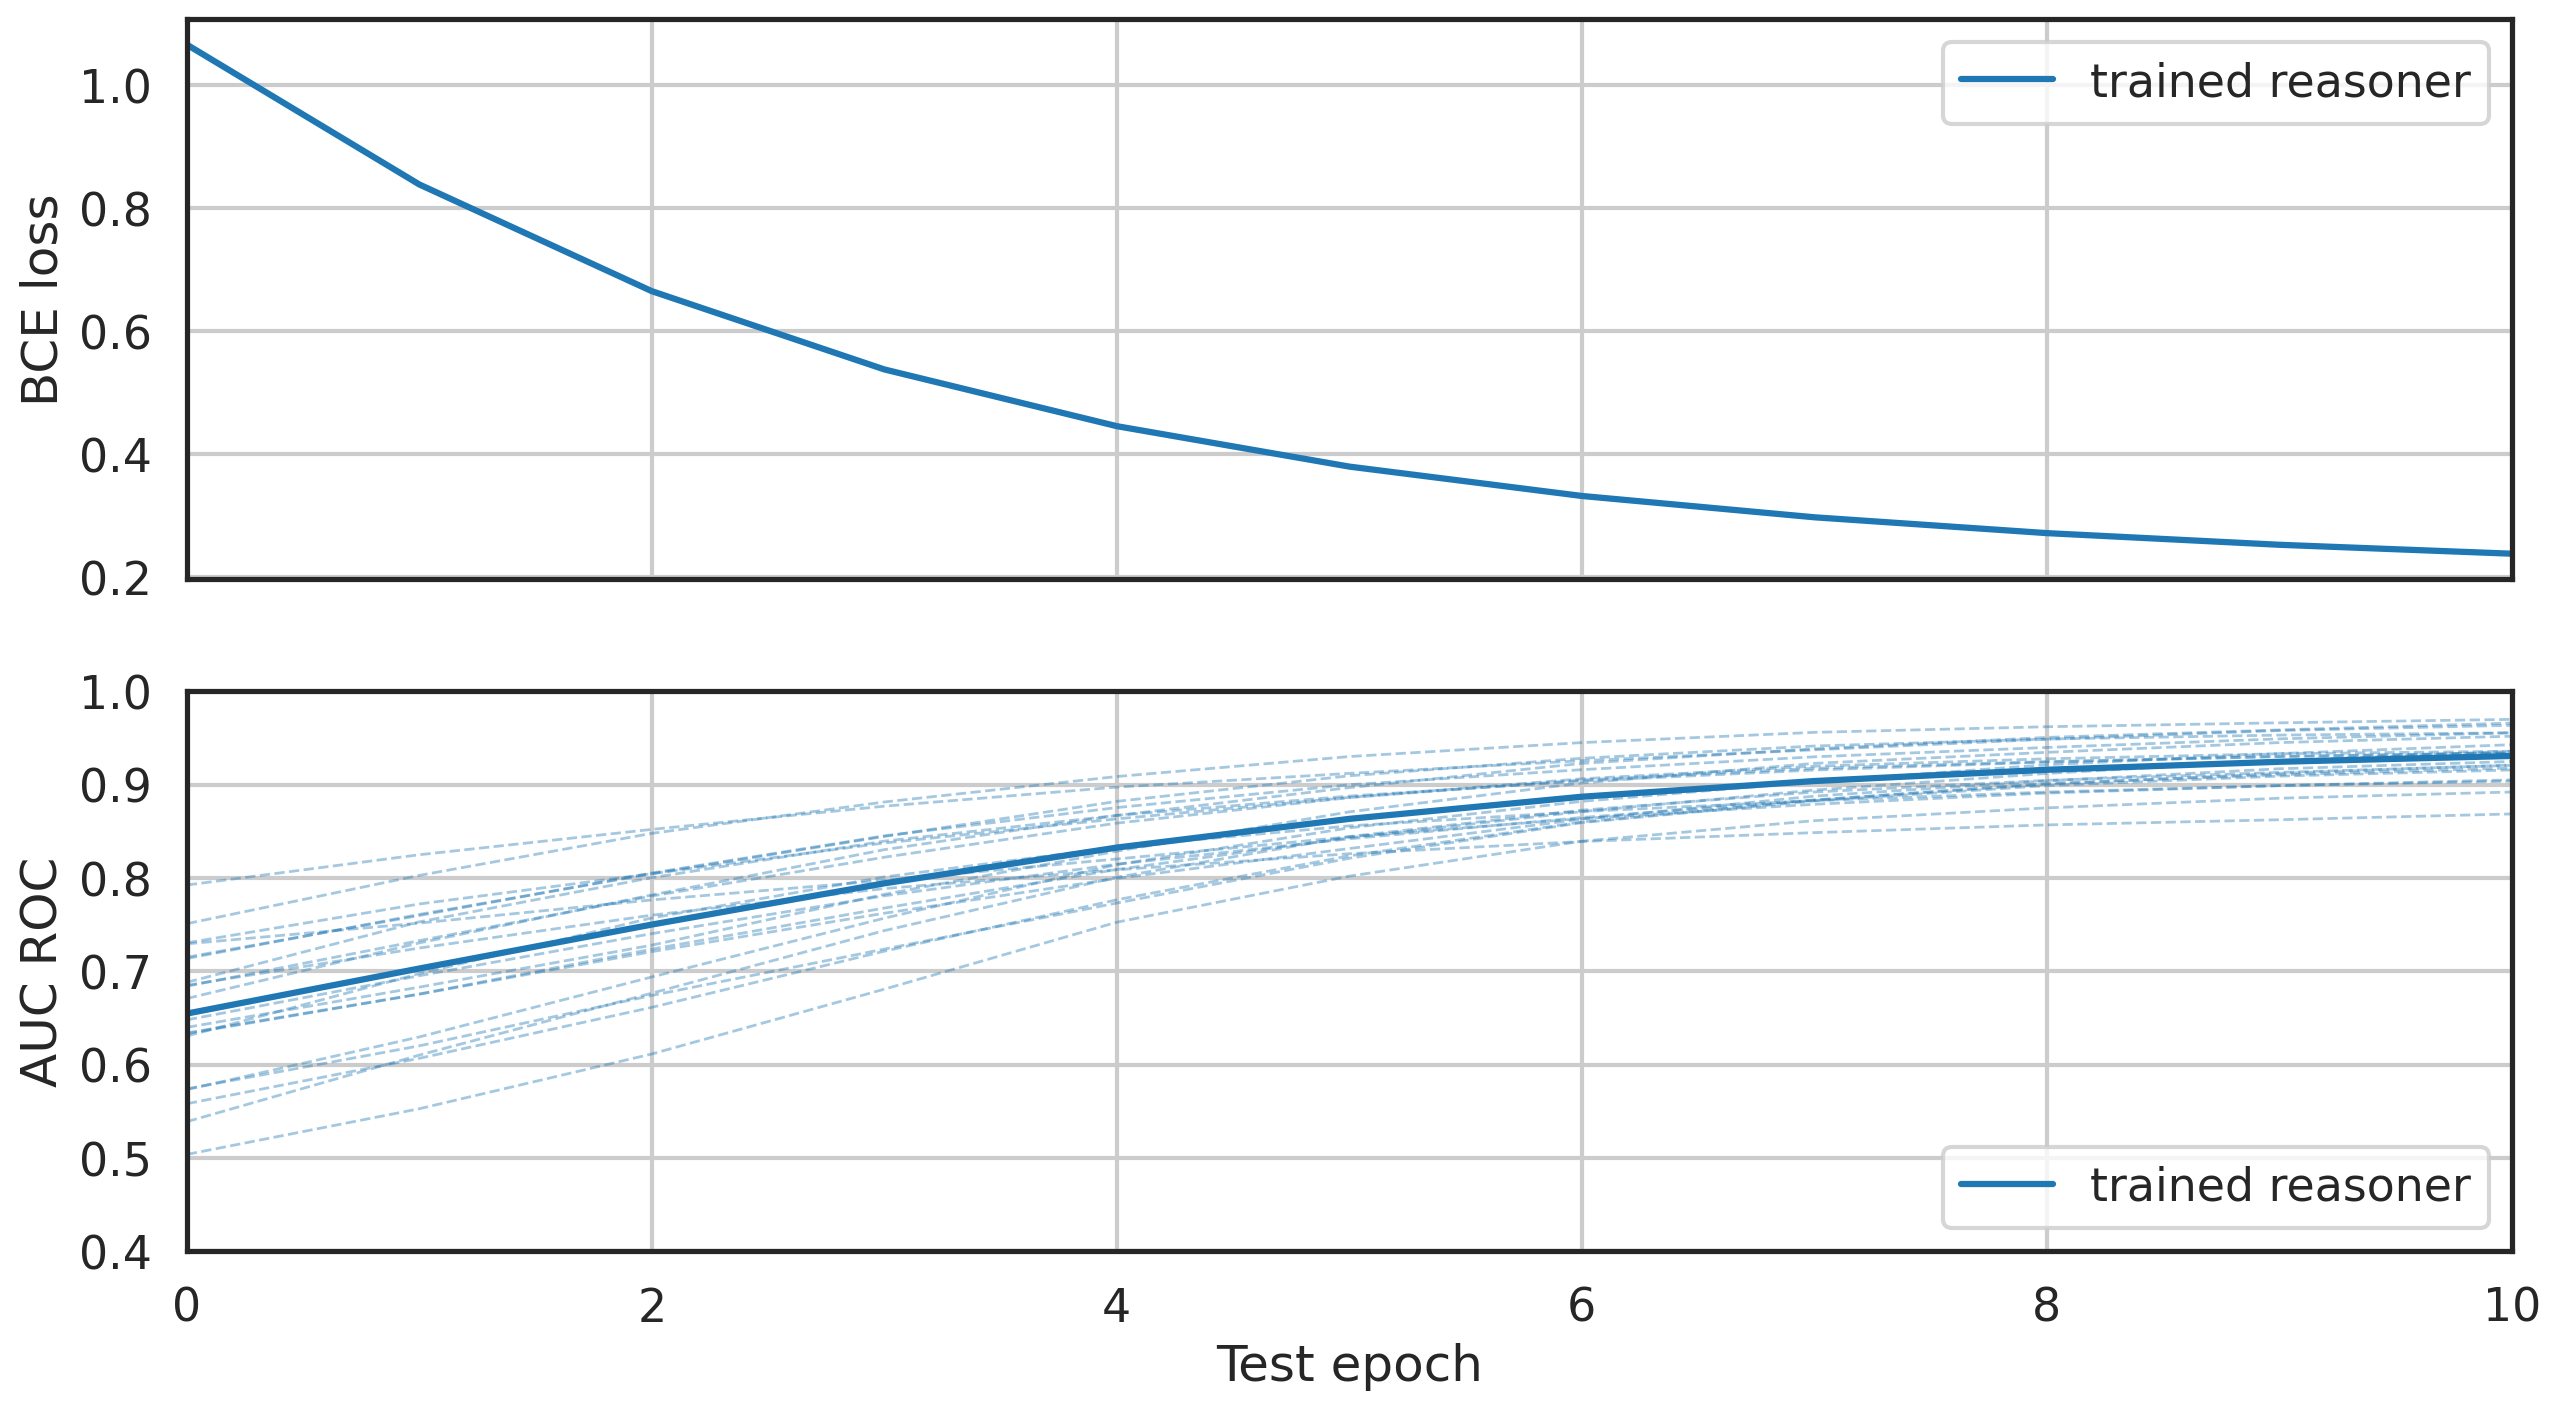

             mean       std     micro
acc      0.913375  0.025627  0.913375
prec     0.834746  0.054874  0.834933
recall   0.746827  0.070569  0.750000
f1       0.787503  0.058971  0.790191
auc_roc  0.924873  0.028029  0.926850
auc_pr   0.870045  0.045863  0.874460


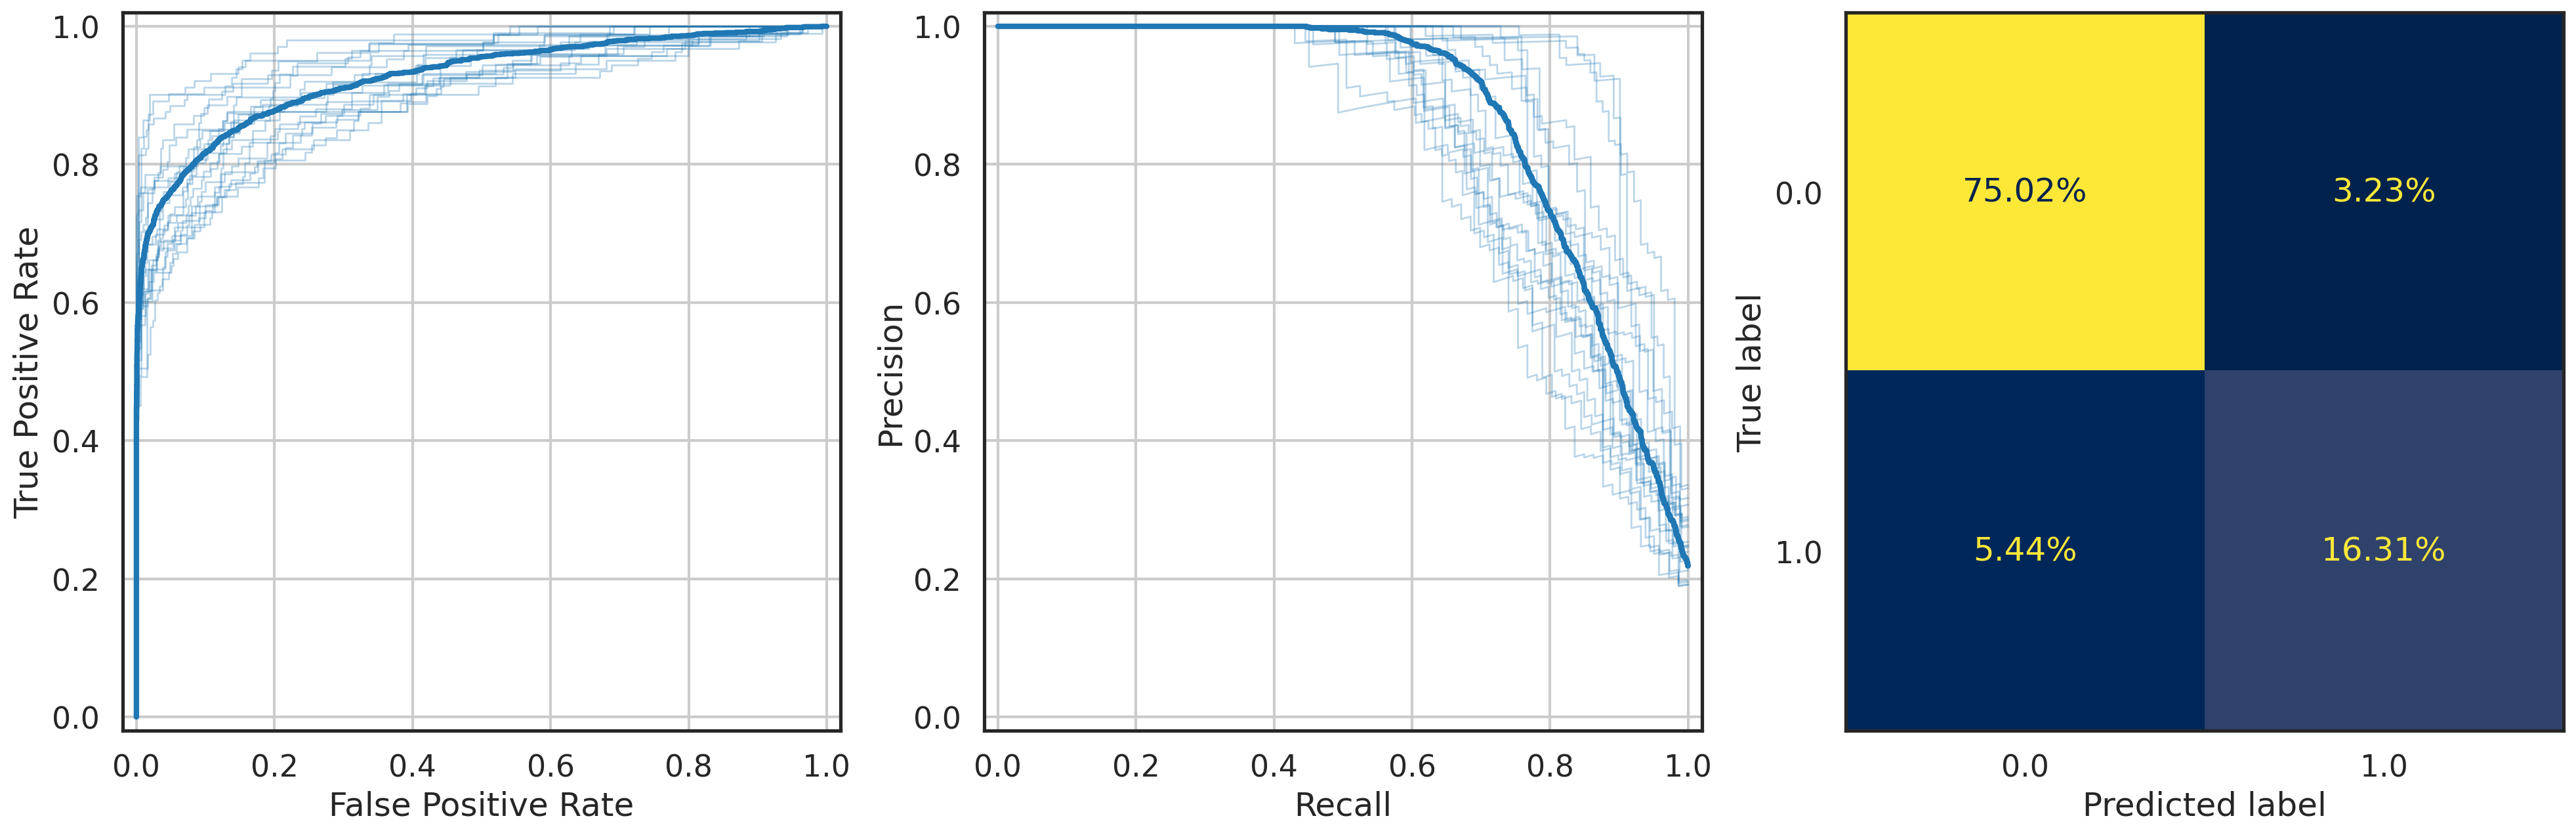

In [9]:
# base = 'local/out/exp/' + ts
# mkdirp(base)
# print(base)

# T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
# df_tr = pd.DataFrame(train_logger.history_tr)
# # df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
# plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))#, Y_te_rand=Y_te_rand))
# test_history.to_csv(base+'/test.csv', index=False)
# test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
# test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te, np.array(Y_te_good), idx_te))
#print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))

In [10]:
T.set_printoptions(precision=4)

In [11]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im_mod(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im_mod( input, input)))
print(np.mean(losses))

tensor([-0.2203,  0.0513,  0.1590,  0.0901,  0.0325,  0.2676, -0.0136,  0.1590,
         0.1143, -0.1036], grad_fn=<SelectBackward0>)
tensor([ 0.1263,  0.0220, -0.0131, -0.0784,  0.1952, -0.0978, -0.0473, -0.0505,
        -0.0727, -0.0746], grad_fn=<AddBackward0>)
0.12003963738679886


In [12]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im_mod(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.3248,  0.2079,  0.1088, -0.2955,  0.3822, -0.0207,  0.1033,  0.1164,
        -0.2647, -0.1437], grad_fn=<SelectBackward0>)
tensor([ 0.3770,  0.1592,  0.0870, -0.3146,  0.3924, -0.0775,  0.0568,  0.0864,
        -0.2187, -0.1712], grad_fn=<AddBackward0>)
0.021883337618783118


In [13]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im_mod(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.1667,  0.3019,  0.0159, -0.0420,  0.1728,  0.2274,  0.2746,  0.0379,
        -0.0221, -0.0842], grad_fn=<SelectBackward0>)
tensor([ 0.1420,  0.0889,  0.0338, -0.0565,  0.1824,  0.0737,  0.1634,  0.0642,
        -0.1165, -0.0451], grad_fn=<AddBackward0>)
0.08707555457949638


In [14]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im_mod(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.3248,  0.2079,  0.1088, -0.2955,  0.3822, -0.0207,  0.1033,  0.1164,
        -0.2647, -0.1437], grad_fn=<SelectBackward0>)
tensor([ 0.1558, -0.0014,  0.0462, -0.1469,  0.1524, -0.0564, -0.0026, -0.0164,
        -0.0279, -0.0064], grad_fn=<AddBackward0>)
0.15960994102060794


In [15]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.3248,  0.2079,  0.1088, -0.2955,  0.3822, -0.0207,  0.1033,  0.1164,
        -0.2647, -0.1437], grad_fn=<SelectBackward0>)
tensor([ 0.3252,  0.2089,  0.1086, -0.2964,  0.3826, -0.0210,  0.1023,  0.1166,
        -0.2647, -0.1439], grad_fn=<SqueezeBackward3>)
tensor(0.0005, grad_fn=<L1LossBackward0>)


In [16]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.0740, -0.2704, -0.0439,  0.3957,  0.0404,  0.2183,  0.7550,  0.0279,
        -0.1043,  0.3512], grad_fn=<SelectBackward0>)
tensor([-0.0739, -0.2698, -0.0433,  0.3955,  0.0405,  0.2182,  0.7542,  0.0282,
        -0.1044,  0.3505], grad_fn=<SqueezeBackward3>)
tensor(0.0004, grad_fn=<L1LossBackward0>)


In [17]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))), trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.and_nn(im_mod(input2, input3)))))
print(trained_reasoner.and_nn(im_mod(trained_reasoner.and_nn(im_mod(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.2165,  0.0307,  0.0554, -0.2016,  0.2400, -0.0915, -0.0031,  0.0138,
        -0.1089, -0.0306], grad_fn=<AddBackward0>)
tensor([ 0.2065,  0.0206,  0.0917, -0.2154,  0.2269, -0.1133, -0.0150, -0.0255,
        -0.0937, -0.0212], grad_fn=<AddBackward0>)
0.018494888022542


In [18]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im_mod(input1, input2)), trained_reasoner.and_nn(im_mod(input2, input1))).item())

print(trained_reasoner.and_nn(im_mod(input1, input2)))
print(trained_reasoner.and_nn(im_mod(input2, input1)))

print(np.mean(losses))

tensor([ 0.0690, -0.0900, -0.0384, -0.0781,  0.0989, -0.1190, -0.0980, -0.1139,
         0.0127,  0.0669], grad_fn=<AddBackward0>)
tensor([ 0.0609, -0.0927, -0.0268, -0.0661,  0.0899, -0.1645, -0.0830, -0.1062,
         0.0020,  0.0490], grad_fn=<AddBackward0>)
0.024919169768691064


In [19]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im_mod(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.0650,  0.0103, -0.1742, -0.0997, -0.0244,  0.0450,  0.0433, -0.0780,
         0.0211, -0.2079], grad_fn=<SelectBackward0>)
tensor([-0.0070, -0.0260, -0.0869, -0.0290,  0.0171,  0.0185,  0.0071, -0.0492,
         0.0102, -0.0241], grad_fn=<AddBackward0>)
0.07190888822078705


In [20]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im_mod(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9995117247104645


In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999817609786987


In [22]:
losses = []
for _ in range(20):
    encoder = encoders[int(np.round(random. random() * (len(encoders) - 1), 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im_mod(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.9999817609786987
